(lecture_11)=
# Ordered Categories
:::{post} Jan 7, 2024
:tags: statistical rethinking, bayesian inference, ordered categories
:category: intermediate
:author: Dustin Stansbury
:::

This notebook is part of the PyMC port of the [Statistical Rethinking 2023](https://github.com/rmcelreath/stat_rethinking_2023) lecture series by Richard McElreath.

[Video - Lecture 11 - Ordered Categories](https://youtu.be/VVQaIkom5D0)# [Lecture 11 - Ordered Categories](https://youtu.be/VVQaIkom5D0?si=FkFkWJkDHV6-R04N)

In [1]:
# Ignore warnings
import warnings

import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import statsmodels.formula.api as smf
import utils as utils
import xarray as xr

from matplotlib import pyplot as plt
from matplotlib import style
from scipy import stats as stats

warnings.filterwarnings("ignore")

# Set matplotlib style
STYLE = "statistical-rethinking-2023.mplstyle"
style.use(STYLE)

# Solving Scientific Problems

## When solving problems on the edge of knowledge

- there's generally not an algorithm available to tell you how to solve it
- best we can do is see lots of examples
- derive a set of general heuristics for how to attack problems
  - try solving a more accessible problem or subproblem
  - e.g. try building a simpler model first, then add complexity
  - ALWAYS CHECK YOUR WORK -- e.g. via simulation


### You Don't always get what you want
- May not be able to estimate the desired estimand
- You'll likely have to compromise
  - e.g. estimating the total effect vs the direct effect
  - sensitivity analysis
  - estimate counterfactuals

# Ethics & Trolley Problem Studies

## Principles studied

Researchers have tried to catalog trolly problem scenarios along multiple feature dimensions, three common features are:

- **Action**: taking an action is less morally permissible than not taking an action (you intervening on a scene is condidered worse than letting the scene play out)
- **Intention**: does the actor's direct goal affect the scenario (e.g. intentially killing one person to save five)
- **Contact**: intentions are worse if the actor comes into direct contact with the object of the action (e.g. directly pushing a person off a bridge to save others)


## Dataset

In [2]:
TROLLEY = utils.load_data("Trolley")
N_TROLLEY_RESPONSES = len(TROLLEY)
N_RESPONSE_CATEGORIES = TROLLEY.response.max()
TROLLEY.head()

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1


- 9330 total responses
- 331 individuals
- 30 different trolley problem scenarios
- vary along action, intention, contact dimensions
- responses are ordered integer values ranging from 1 to 7 indicating the "appropriateness" of action
  - not counts
  - ordered but not continous ordered
  - bounded

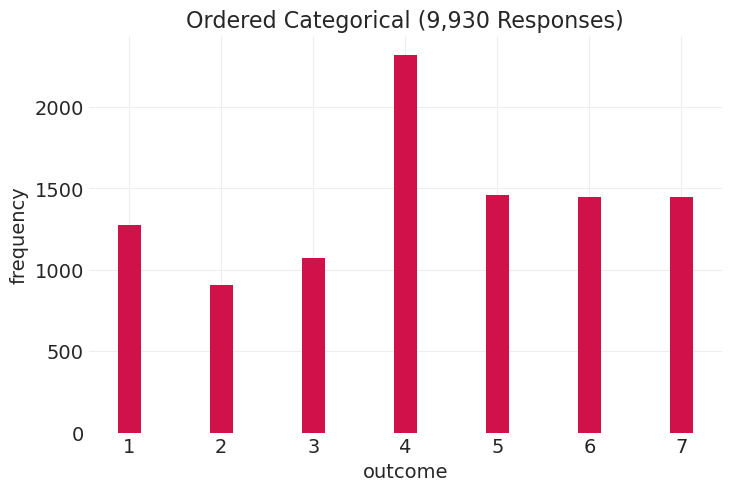

In [3]:
response_counts = TROLLEY.groupby("response").count()["action"]
bars = plt.bar(response_counts.index, response_counts.values, width=0.25)
plt.xlabel("outcome")
plt.ylabel("frequency")
plt.title(f"Ordered Categorical ({N_TROLLEY_RESPONSES:,} Responses)");

1) Estimand
How do <span style="color:blue">**Action, intention, and contact**</span> influence <span style="color:red">**response**</span>

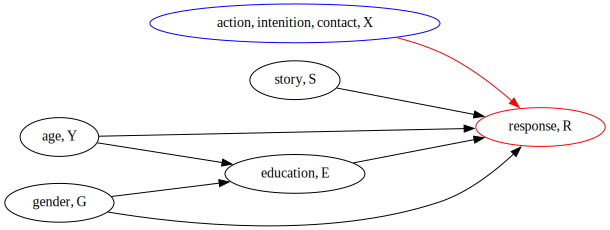

In [4]:
utils.draw_causal_graph(
    edge_list=[("X", "R"), ("S", "R"), ("E", "R"), ("Y", "R"), ("G", "R"), ("Y", "E"), ("G", "E")],
    node_props={
        "X": {"color": "blue", "label": "action, intenition, contact, X"},
        "R": {"color": "red", "label": "response, R"},
        "S": {"label": "story, S"},
        "E": {"label": "education, E"},
        "Y": {"label": "age, Y"},
        "G": {"label": "gender, G"},
    },
    edge_props={
        ("X", "R"): {"color": "red"},
    },
    graph_direction="LR",
)

## Ordered Categories

- Discrete categories
- Categories have an order, thus 7 > 6 > 5, etc., but 7 not necessarily 7x that of 1
- Distance between each values is not constant, and unclear
- Anchor points (e.g. 4 here is "meh")
  - Different people have different anchor points

## Ordered = Cumulative

- rather than $p(x=5)$, $p(x<=5)$
  
### Cumulative Distribution Function

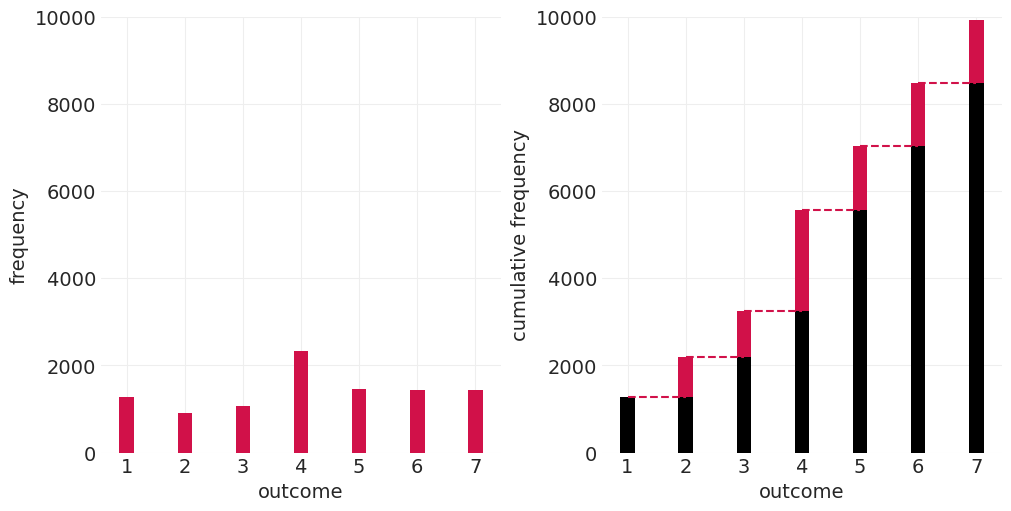

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
xticks = range(1, 8)

cumulative_counts = response_counts.cumsum()

plt.sca(axs[0])
plt.bar(response_counts.index, response_counts.values, color="C0", width=0.25)
plt.xlabel("outcome")
plt.xticks(xticks)
plt.ylabel("frequency")
plt.ylim([0, 10_000])

# Cumulative frequency
plt.sca(axs[1])
plt.bar(response_counts.index, cumulative_counts.values, color="k", width=0.25)
offsets = cumulative_counts.values[1:] - response_counts.values[1:]
plt.bar(
    cumulative_counts.index[1:], response_counts.values[1:], bottom=offsets, color="C0", width=0.25
)

for ii, y in enumerate(offsets):
    x0 = ii + 1
    x1 = x0 + 1
    plt.plot((x0, x1), (y, y), color="C0", linestyle="--")

plt.xlabel("outcome")
plt.xticks(xticks)
plt.ylabel("cumulative frequency")
plt.ylim([0, 10_000]);

### Cumulative log odds

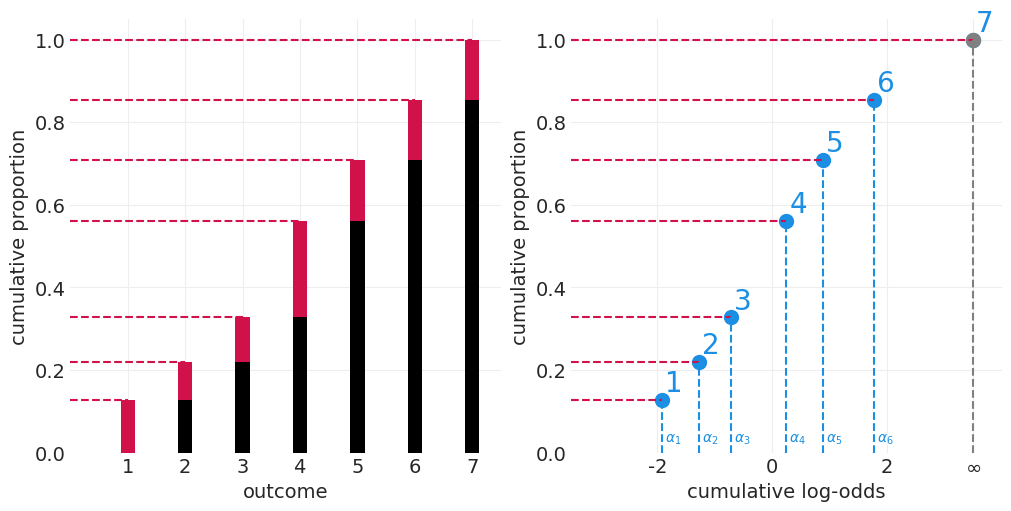

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

response_probs = response_counts / response_counts.sum()
cumulative_probs = response_probs.cumsum()

# Plot  Cumulative proportion
plt.sca(axs[0])
plt.bar(cumulative_probs.index, cumulative_probs.values, color="k", width=0.25)
offsets = cumulative_probs.values - response_probs.values
plt.bar(cumulative_probs.index, response_probs.values, bottom=offsets, color="C0", width=0.25)

offsets = np.append(offsets, 1)  # add p = 1 condition
for ii, y in enumerate(offsets[1:]):
    x1 = ii + 1
    plt.plot((0, x1), (y, y), color="C0", linestyle="--")

plt.xlabel("outcome")
plt.xticks(xticks)
plt.xlim([0, 7.5])
plt.ylabel("cumulative proportion")
plt.ylim([0, 1.05])

# Cumulative proportion vs cumulative log-odds
infty = 3.5  # "Infinity" log odds x-value for plots
neg_infty = -1 * infty
cumulative_log_odds = [np.log(p / (1 - p)) for p in cumulative_probs]
cumulative_log_odds[-1] = infty

# Plot cumulative data points
plt.sca(axs[1])
plt.scatter(cumulative_log_odds, cumulative_probs.values, color="C1", s=100)
plt.scatter(infty, 1, color="gray", s=100)  # add point for Infinity
for ii, (clo, clp) in enumerate(zip(cumulative_log_odds, cumulative_probs.values)):

    # Add cumulative proportion
    plt.plot((neg_infty, clo), (clp, clp), color="C0", linestyle="--")

    # Add & label cutpoints
    if ii < N_RESPONSE_CATEGORIES - 1:
        plt.plot((clo, clo), (0, clp), color="C1", linestyle="--")
        plt.text(clo + 0.05, 0.025, f"$\\alpha_{ii+1}$", color="C1", fontsize=10)
    else:
        plt.plot((clo, clo), (0, clp), color="grey", linestyle="--")

    # Annotate data points
    plt.text(clo + 0.05, clp + 0.02, f"{ii+1}", color="C1", fontsize=20)

plt.xlabel("cumulative log-odds")
plt.xlim([neg_infty, infty + 0.5])
plt.xticks([-2, 0, 2, infty], labels=[-2, 0, 2, "$\\infty$"])
plt.ylabel("cumulative proportion")
plt.ylim([0, 1.05])

plt.sca(axs[0])

### Ordering responses with CDF

Using the CDF, we can establish cut points $\alpha_R$ on the cumulative log odds that correspond with the cumulative probability of that response (or one smaller). Thus the CDF gives us a proxy for order.

### Calculating $P(R_i=k)$

$$
P(R_i=k) = P(R_i \le k ) - P(R_i \le k - 1)
$$

For example, for $k = 3$
$$
P(R_i=3) = P(R_i\le3) - P(R_i\le2)
$$

### Setting up the GLM

We model the _cumulative_ log odds as each break point $\alpha_k$

$$
\log \frac{P(R<=k)}{1 - P(R<=k)} = \alpha_k
$$

### Where's the GLM?

How can we make this a function of predictors

1. Have a $\alpha_k$ for each predictor variable
2. Use an offset $\phi_i$ for each data point that is a function of the predictors

$$
\begin{align*}
\log \frac{P(R<=k)}{1 - P(R<=k)} &= \alpha_k + \phi_i \\
\phi_i &= \beta_A A_i + \beta_C C_i + \beta_I I_i \\
\end{align*}
$$


### Demonstrating the Effect of $\phi$ on Response Distribution
Changing $\phi$ "squishes" or "stretches" the cumulative histogram

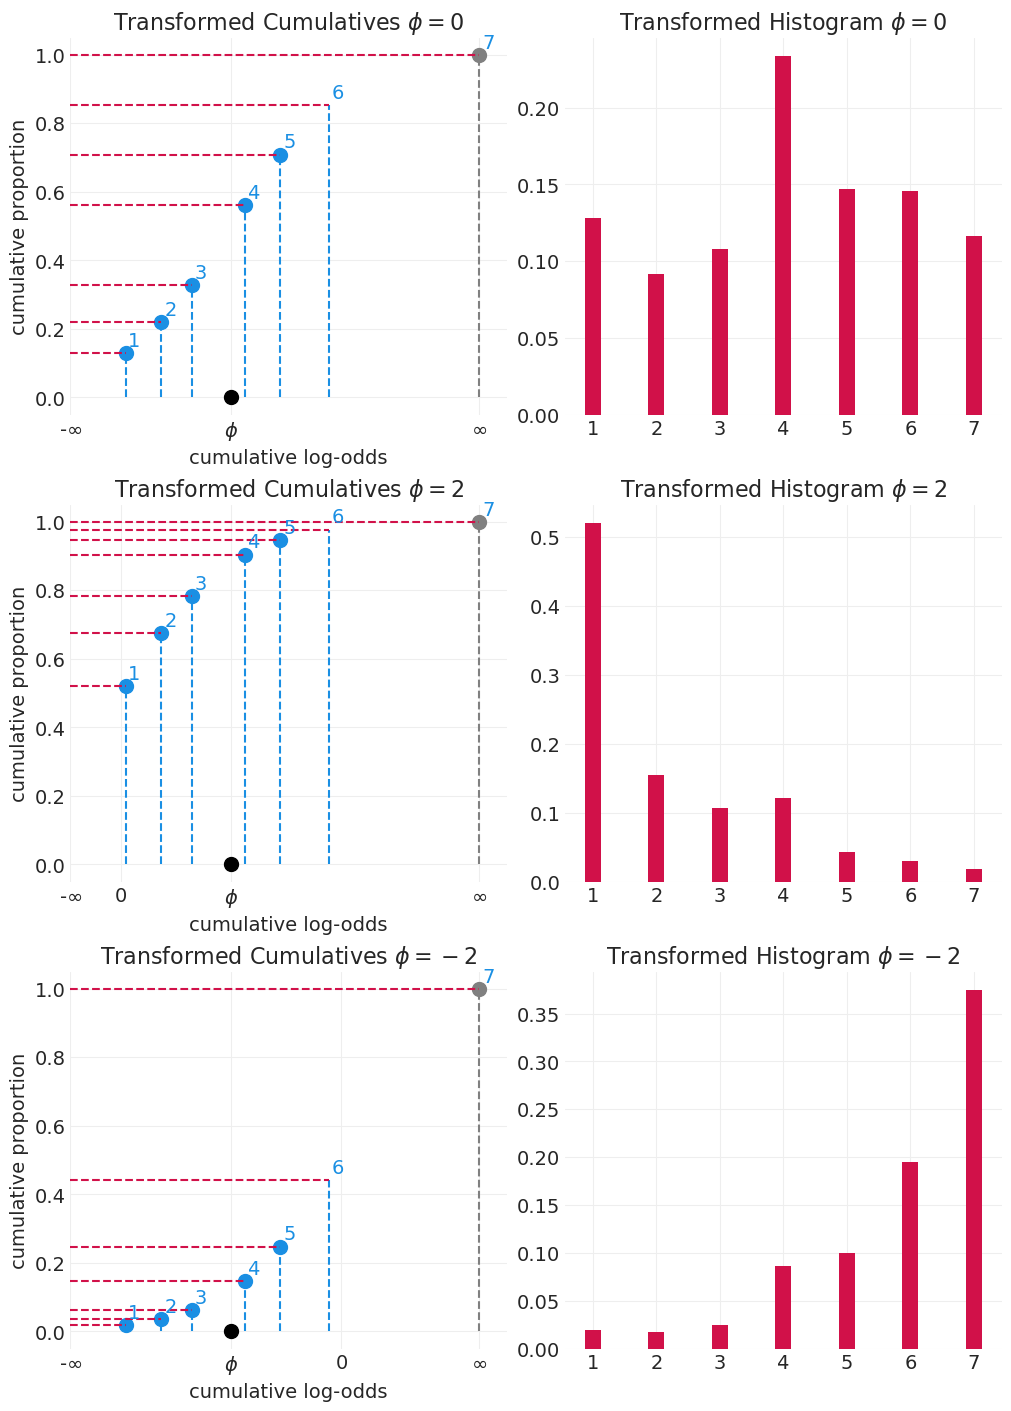

In [7]:
def plot_cumulative_log_odds_and_cumulative_probs(cumulative_log_odds, cumulative_probs, phi):
    infity = max(cumulative_log_odds) + 1
    neg_infity = min(cumulative_log_odds) - 1

    # Plot cumulative data points
    plt.scatter(cumulative_log_odds[:-2], cumulative_probs[:-2], color="C1", s=100)
    plt.scatter(infity, 1, color="gray", s=100)  # add point for Infinity

    for ii, (clo, clp) in enumerate(zip(cumulative_log_odds, cumulative_probs)):

        # Add & label cutpoints
        if ii < N_RESPONSE_CATEGORIES - 1:
            plt.plot((clo, clo), (0, clp), color="C1", linestyle="--")
            # Add cumulative proportion
            plt.plot((neg_infity, clo), (clp, clp), color="C0", linestyle="--")
            # Annotate data points
            plt.text(clo + 0.05, clp + 0.02, f"{ii+1}", color="C1", fontsize=14)
        else:
            plt.plot((infity, infity), (0, 1), color="grey", linestyle="--")
            plt.plot((neg_infity, infity), (1, 1), color="C0", linestyle="--")
            # Annotate data points
            plt.text(infity + 0.05, 1 + 0.02, f"{ii+1}", color="C1", fontsize=14)

    plt.xlabel("cumulative log-odds")
    plt.xlim([neg_infity, infity + 0.5])
    if phi < 0:
        xticks = [neg_infity, phi, 0, infity]
        xtick_labels = ["-$\\infty$", "$\\phi$", 0, "$\\infty$"]
    elif phi > 0:
        xticks = [neg_infity, 0, phi, infity]
        xtick_labels = ["-$\\infty$", 0, "$\\phi$", "$\\infty$"]
    else:
        xticks = [neg_infity, phi, infity]
        xtick_labels = ["-$\\infty$", "$\\phi$", "$\\infty$"]

    plt.xticks(xticks, labels=xtick_labels)
    plt.ylabel("cumulative proportion")
    plt.ylim([-0.05, 1.05])


def plot_cumulative_probs_bar(cumulative_probs):
    xs = range(1, len(cumulative_probs) + 1)
    diff_probs = [c for c in cumulative_probs]
    diff_probs.insert(0, 0)
    probs = np.diff(diff_probs)
    plt.bar(xs, probs, color="C0", width=0.25)


def show_phi_effect(cumulative_log_odds, phi=0):
    if not isinstance(phi, list):
        phi = [phi]
    n_phis = len(phi)

    fig, axs = plt.subplots(n_phis, 2, figsize=(10, 8 + n_phis * 2))

    for ii, ph in enumerate(phi):

        # Shift the cumulative log odds by phi
        cumulative_log_odds_plus_phi = [v + ph for v in cumulative_log_odds]

        # Resulting cumulative probabilities
        cumulative_probs_plus_phi = [utils.invlogit(c) for c in cumulative_log_odds_plus_phi]

        plt.sca(axs[ii][0])

        plot_cumulative_log_odds_and_cumulative_probs(
            cumulative_log_odds=cumulative_log_odds_plus_phi,
            cumulative_probs=cumulative_probs_plus_phi,
            phi=ph,
        )
        plt.scatter(ph, 0, s=100, color="k")
        plt.title(f"Transformed Cumulatives $\\phi={ph}$")

        plt.sca(axs[ii][1])
        plot_cumulative_probs_bar(cumulative_probs_plus_phi)
        plt.title(f"Transformed Histogram $\\phi={ph}$")


show_phi_effect(cumulative_log_odds, phi=[0, 2, -2])

## Statistical Model
### Starting off easy

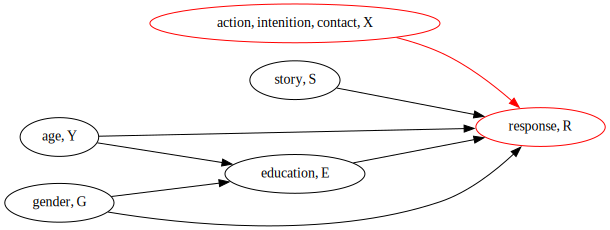

In [8]:
utils.draw_causal_graph(
    edge_list=[("X", "R"), ("S", "R"), ("E", "R"), ("Y", "R"), ("G", "R"), ("Y", "E"), ("G", "E")],
    node_props={
        "X": {"color": "red", "label": "action, intenition, contact, X"},
        "R": {"color": "red", "label": "response, R"},
        "S": {"label": "story, S"},
        "E": {"label": "education, E"},
        "Y": {"label": "age, Y"},
        "G": {"label": "gender, G"},
    },
    edge_props={
        ("X", "R"): {"color": "red"},
    },
    graph_direction="LR",
)

$$
\begin{align*}
R_i &\sim \text{OrderedLogit}(\phi_i, \alpha) \\
\phi_i &= \beta_A A_i + \beta_C C_i + \beta_I I_i \\
\alpha_j &\sim \mathcal N(0,1) \\
\beta_{A,C,I} &\sim \mathcal N(0, .5)
\end{align*}
$$

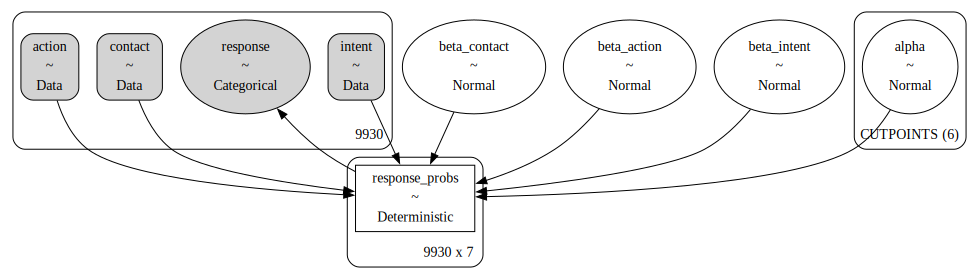

In [9]:
# Set up data / coords
RESPONSE_ID, RESPONSE = pd.factorize(TROLLEY.response.astype(int), sort=True)
N_RESPONSE_CLASSES = len(RESPONSE)
CUTPOINTS = np.arange(1, N_RESPONSE_CLASSES).astype(int)

# for labeling cutpoints
coords = {"CUTPOINTS": CUTPOINTS}
with pm.Model(coords=coords) as basic_ordered_logistic_model:

    # Data for posetior predictions
    action = pm.Data("action", TROLLEY.action.astype(float))
    intent = pm.Data("intent", TROLLEY.intention.astype(float))
    contact = pm.Data("contact", TROLLEY.contact.astype(float))

    # Priors
    beta_action = pm.Normal("beta_action", 0, 0.5)
    beta_intent = pm.Normal("beta_intent", 0, 0.5)
    beta_contact = pm.Normal("beta_contact", 0, 0.5)

    cutpoints = pm.Normal(
        "alpha",
        mu=0,
        sigma=1,
        transform=pm.distributions.transforms.univariate_ordered,
        shape=N_RESPONSE_CLASSES - 1,
        initval=np.arange(N_RESPONSE_CLASSES - 1)
        - 2.5,  # use ordering (with coarse log-odds centering) for init
        dims="CUTPOINTS",
    )

    # Likelihood
    phi = beta_action * action + beta_intent * intent + beta_contact * contact
    pm.OrderedLogistic("response", cutpoints=cutpoints, eta=phi, observed=RESPONSE_ID)

pm.model_to_graphviz(basic_ordered_logistic_model)

In [10]:
with basic_ordered_logistic_model:
    basic_ordered_logistic_inference = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_action, beta_intent, beta_contact, alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


In [11]:
az.summary(
    basic_ordered_logistic_inference,
    var_names=["beta_contact", "beta_intent", "beta_action", "alpha"],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_contact,-0.943,0.050,-1.032,-0.849,0.001,0.001,3029.0,2894.0,1.0
beta_intent,-0.711,0.036,-0.777,-0.644,0.001,0.000,3348.0,3184.0,1.0
beta_action,-0.695,0.040,-0.770,-0.622,0.001,0.001,2522.0,3032.0,1.0
alpha[1],-2.819,0.046,-2.898,-2.726,0.001,0.001,1769.0,2416.0,1.0
alpha[2],-2.138,0.041,-2.214,-2.058,0.001,0.001,1919.0,2408.0,1.0
alpha[3],-1.556,0.039,-1.625,-1.479,0.001,0.001,2038.0,2547.0,1.0
alpha[4],-0.537,0.036,-0.610,-0.472,0.001,0.001,2402.0,3133.0,1.0
alpha[5],0.131,0.037,0.066,0.204,0.001,0.001,2475.0,2695.0,1.0
alpha[6],1.037,0.040,0.960,1.108,0.001,0.001,2825.0,3296.0,1.0


### Posterior Predictive Distributions

In [12]:
def run_basic_trolley_counterfactual(action=0, intent=0, contact=0, ax=None):
    with basic_ordered_logistic_model:
        pm.set_data(
            {
                "action": xr.DataArray([action] * N_TROLLEY_RESPONSES),
                "intent": xr.DataArray([intent] * N_TROLLEY_RESPONSES),
                "contact": xr.DataArray([contact] * N_TROLLEY_RESPONSES),
            }
        )
        ppd = pm.sample_posterior_predictive(
            basic_ordered_logistic_inference, extend_inferencedata=False
        )

    # recode back to 1-7
    posterior_predictive = ppd.posterior_predictive["response"] + 1

    # Posterior predictive density. Due to idiosyncracies with plt.hist(),
    # az.plot_density() refuses to center on integer ticks, so we just do
    # it manually with numpy and plt.bar()
    if ax is not None:
        plt.sca(ax)
    else:
        plt.subplots(figsize=(6, 3))
    counts, bins = np.histogram(posterior_predictive.values.ravel(), bins=np.arange(1, 9))
    total_counts = counts.sum()
    counts = [c / total_counts for c in counts]
    plt.bar(bins[:-1], counts, width=0.25)

    plt.xlim([0.5, 7.5])
    plt.xlabel("response")
    plt.ylabel("density")
    plt.title(f"action={action}; intent={intent}; contact={contact}")

Sampling: [response]


Output()

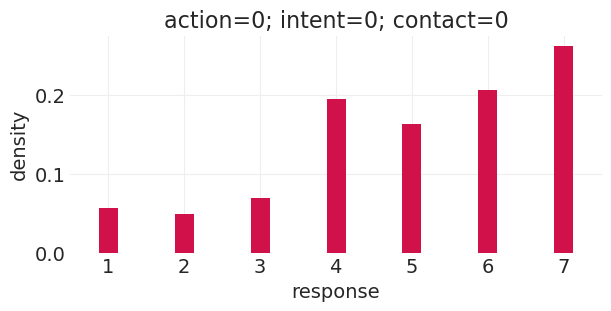

In [13]:
run_basic_trolley_counterfactual(action=0, intent=0, contact=0)

Sampling: [response]


Output()

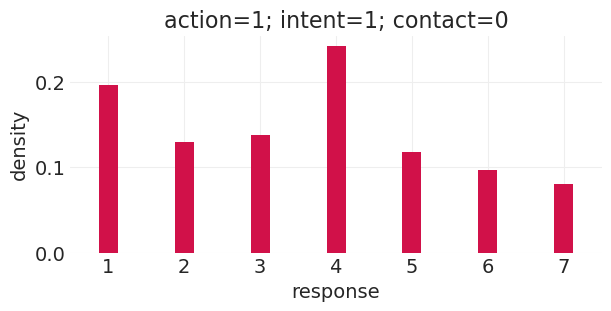

In [14]:
run_basic_trolley_counterfactual(action=1, intent=1, contact=0)

Sampling: [response]


Output()

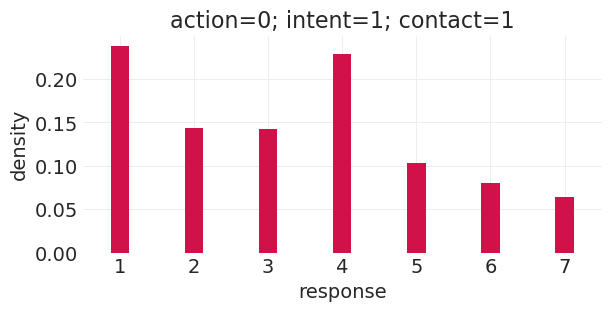

In [15]:
run_basic_trolley_counterfactual(action=0, intent=1, contact=1)

## What about competing causes?

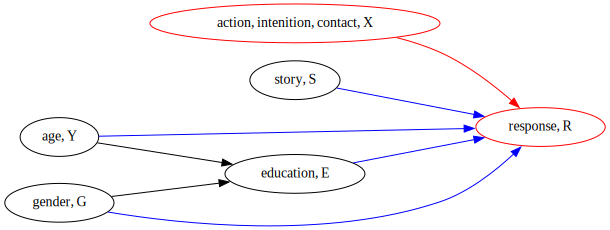

In [16]:
utils.draw_causal_graph(
    edge_list=[("X", "R"), ("S", "R"), ("E", "R"), ("Y", "R"), ("G", "R"), ("Y", "E"), ("G", "E")],
    node_props={
        "X": {"color": "red", "label": "action, intenition, contact, X"},
        "R": {"color": "red", "label": "response, R"},
        "S": {"label": "story, S"},
        "E": {"label": "education, E"},
        "Y": {"label": "age, Y"},
        "G": {"label": "gender, G"},
    },
    edge_props={
        ("X", "R"): {"color": "red"},
        ("Y", "R"): {"color": "blue"},
        ("E", "R"): {"color": "blue"},
        ("S", "R"): {"color": "blue"},
        ("G", "R"): {"color": "blue"},
    },
    graph_direction="LR",
)

### Total effect of gender

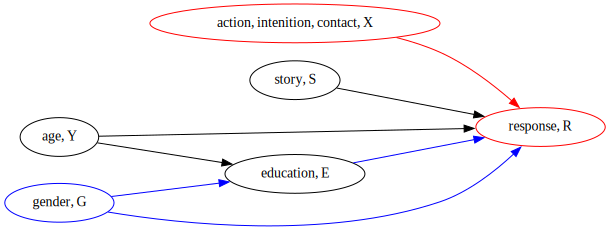

In [17]:
utils.draw_causal_graph(
    edge_list=[("X", "R"), ("S", "R"), ("E", "R"), ("Y", "R"), ("G", "R"), ("Y", "E"), ("G", "E")],
    node_props={
        "X": {"label": "action, intenition, contact, X", "color": "red"},
        "R": {"color": "red", "label": "response, R"},
        "S": {"label": "story, S"},
        "E": {"label": "education, E"},
        "Y": {"label": "age, Y"},
        "G": {"label": "gender, G", "color": "blue"},
    },
    edge_props={
        ("G", "R"): {"color": "blue"},
        ("G", "E"): {"color": "blue"},
        ("E", "R"): {"color": "blue"},
        ("X", "R"): {"color": "red"},
    },
    graph_direction="LR",
)

$$
\begin{align*}
R_i &\sim OrderedLogit(\phi_i, \alpha) \\
\phi_i &= \beta_{A, G[i]} A_i + \beta_{C, G[i]} C_i + \beta_{I, G[i]} I_i \\
\alpha_j &\sim \mathcal N(0,1) \\
\beta_* &\sim \mathcal N(0, .5)
\end{align*}
$$

### Fit the gender-stratified model

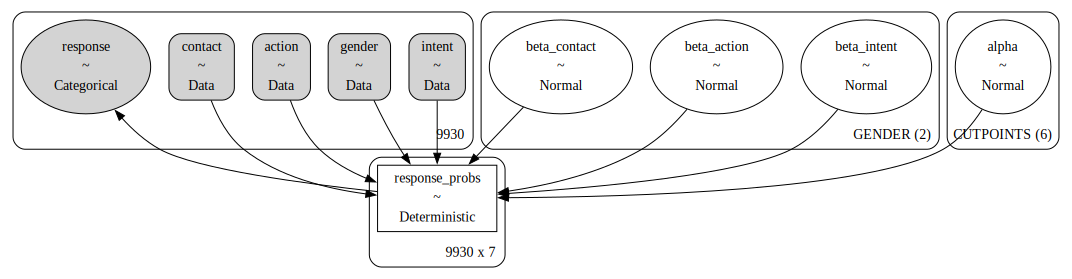

In [18]:
GENDER_ID, GENDER = pd.factorize(["M" if m else "F" for m in TROLLEY.male.values])

coords = {"GENDER": GENDER, "CUTPOINTS": CUTPOINTS}
with pm.Model(coords=coords) as total_effect_gender_model:

    # Data for posetior predictions
    action = pm.Data("action", TROLLEY.action.astype(float))
    intent = pm.Data("intent", TROLLEY.intention.astype(float))
    contact = pm.Data("contact", TROLLEY.contact.astype(float))
    gender = pm.Data("gender", GENDER_ID)

    # Priors
    beta_action = pm.Normal("beta_action", 0, 0.5, dims="GENDER")
    beta_intent = pm.Normal("beta_intent", 0, 0.5, dims="GENDER")
    beta_contact = pm.Normal("beta_contact", 0, 0.5, dims="GENDER")

    cutpoints = pm.Normal(
        "alpha",
        mu=0,
        sigma=1,
        transform=pm.distributions.transforms.univariate_ordered,
        shape=N_RESPONSE_CLASSES - 1,
        initval=np.arange(N_RESPONSE_CLASSES - 1)
        - 2.5,  # use ordering (with coarse log-odds centering) for init
        dims="CUTPOINTS",
    )

    # Likelihood
    phi = (
        beta_action[gender] * action + beta_intent[gender] * intent + beta_contact[gender] * contact
    )

    pm.OrderedLogistic("response", cutpoints=cutpoints, eta=phi, observed=RESPONSE_ID)

pm.model_to_graphviz(total_effect_gender_model)

In [19]:
with total_effect_gender_model:
    total_effect_gender_inference = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_action, beta_intent, beta_contact, alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


In [20]:
az.summary(
    total_effect_gender_inference, var_names=["beta_action", "beta_intent", "beta_contact", "alpha"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_action[F],-0.880,0.051,-0.985,-0.791,0.001,0.001,3392.0,2771.0,1.0
beta_action[M],-0.527,0.047,-0.618,-0.441,0.001,0.001,3353.0,3070.0,1.0
beta_intent[F],-0.895,0.048,-0.981,-0.802,0.001,0.001,3386.0,3078.0,1.0
beta_intent[M],-0.554,0.044,-0.634,-0.467,0.001,0.001,3778.0,2637.0,1.0
beta_contact[F],-1.059,0.066,-1.181,-0.935,0.001,0.001,3581.0,3001.0,1.0
beta_contact[M],-0.834,0.061,-0.948,-0.721,0.001,0.001,3350.0,2956.0,1.0
alpha[1],-2.828,0.046,-2.913,-2.740,0.001,0.001,2141.0,2476.0,1.0
alpha[2],-2.147,0.041,-2.221,-2.069,0.001,0.001,2068.0,2628.0,1.0
alpha[3],-1.562,0.038,-1.631,-1.489,0.001,0.001,2153.0,2425.0,1.0
alpha[4],-0.530,0.036,-0.599,-0.466,0.001,0.000,2609.0,2927.0,1.0


### Running Counterfactuals

In [21]:
def run_total_gender_counterfactual(action=0, intent=0, contact=0, gender=0, ax=None):
    with total_effect_gender_model:
        # hrmm, xr.DataArray doesn't seem to facilitate / speed up predictions 🤔
        pm.set_data(
            {
                "action": xr.DataArray([action] * N_TROLLEY_RESPONSES),
                "intent": xr.DataArray([intent] * N_TROLLEY_RESPONSES),
                "contact": xr.DataArray([contact] * N_TROLLEY_RESPONSES),
                "gender": xr.DataArray([gender] * N_TROLLEY_RESPONSES),
            }
        )
        ppd = pm.sample_posterior_predictive(
            total_effect_gender_inference, extend_inferencedata=False
        )

    # recode back to 1-7
    posterior_predictive = ppd.posterior_predictive["response"] + 1

    # Posterior predictive density. Due to idiosyncracies with plt.hist(),
    # az.plot_density() refuses to center on integer ticks, so we just do
    # it manually with numpy and plt.bar()
    if ax is not None:
        plt.sca(ax)
    else:
        plt.subplots(figsize=(6, 3))
    counts, bins = np.histogram(posterior_predictive.values.ravel(), bins=np.arange(1, 9))
    total_counts = counts.sum()
    counts = [c / total_counts for c in counts]
    plt.bar(bins[:-1], counts, width=0.25)

    plt.xlim([0.5, 7.5])
    plt.xlabel("response")
    plt.ylabel("density")
    plt.title(f"action={action}; intent={intent}; contact={contact}; gender={gender}")

Sampling: [response]


Output()

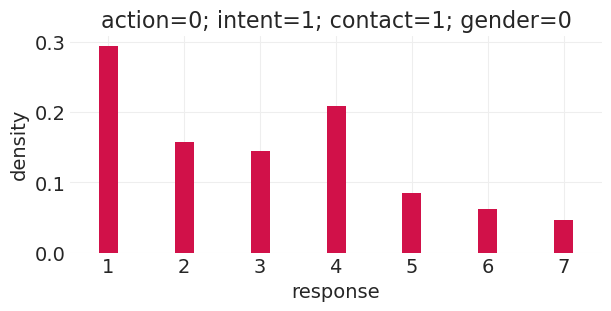

In [22]:
run_total_gender_counterfactual(action=0, intent=1, contact=1, gender=0)

Sampling: [response]


Output()

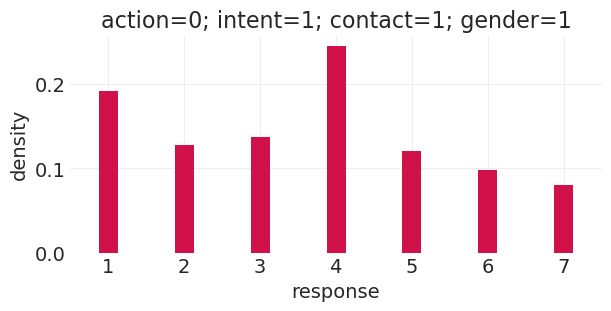

In [23]:
run_total_gender_counterfactual(action=0, intent=1, contact=1, gender=1)

## Hang on!  This is a <span style="color:blue">voluntary</span> sample.

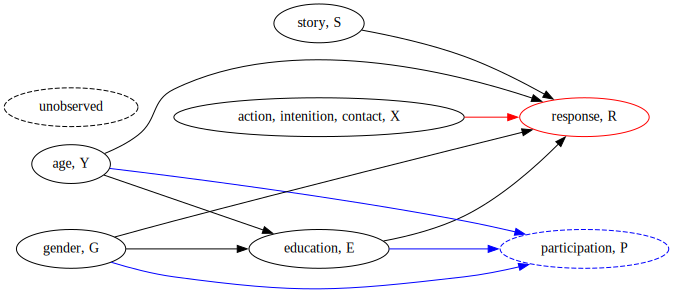

In [24]:
utils.draw_causal_graph(
    edge_list=[
        ("X", "R"),
        ("S", "R"),
        ("E", "R"),
        ("Y", "R"),
        ("G", "R"),
        ("Y", "E"),
        ("G", "E"),
        ("E", "P"),
        ("Y", "P"),
        ("G", "P"),
    ],
    node_props={
        "X": {"label": "action, intenition, contact, X"},
        "R": {"color": "red", "label": "response, R"},
        "S": {"label": "story, S"},
        "E": {"label": "education, E"},
        "Y": {"label": "age, Y"},
        "G": {"label": "gender, G"},
        "P": {"label": "participation, P", "color": "blue", "style": "dashed"},
        "unobserved": {"style": "dashed"},
    },
    edge_props={
        ("E", "P"): {"color": "blue"},
        ("Y", "P"): {"color": "blue"},
        ("G", "P"): {"color": "blue"},
        ("X", "R"): {"color": "red"},
    },
    graph_direction="LR",
)

### Voluntary Samples, Participation, and Endogenous Selection
- Age, Education, and Gender all contribute to an unmeasured variable Participation
- Participation is a collider: conditioning causes, E, Y, G to covary
- **Not actually possible to estimate the Total Effect of Gender**
  - We **CAN estimate the _Direct Effect_ of Gender $G$ by stratifying by Education $E$ and Age $Y$**

#### Looking at the distribution of Education and Age in the sample

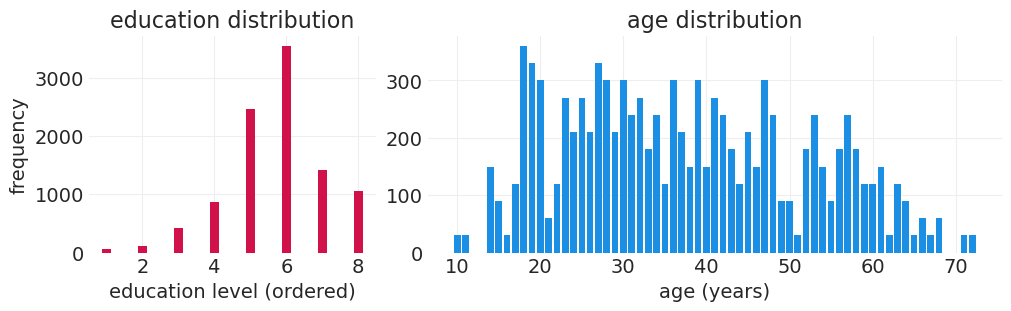

In [25]:
_, axs = plt.subplots(1, 2, figsize=(10, 3), gridspec_kw={"width_ratios": [2, 4]})

EDUCATION_ORDERED_LIST = [
    "Elementary School",
    "Middle School",
    "Some High School",
    "High School Graduate",
    "Some College",
    "Bachelor's Degree",
    "Master's Degree",
    "Graduate Degree",
]
EDUCUATION_MAP = {edu: ii + 1 for ii, edu in enumerate(EDUCATION_ORDERED_LIST)}
EDUCUATION_MAP_R = {v: k for k, v in EDUCUATION_MAP.items()}
TROLLEY["education_level"] = TROLLEY.edu.map(EDUCUATION_MAP)
TROLLEY["education"] = TROLLEY.education_level.map(EDUCUATION_MAP_R)


edu = TROLLEY.groupby("edu").count()[["case"]].rename(columns={"case": "count"})
edu.reset_index(inplace=True)
edu["edu_level"] = edu["edu"].map(EDUCUATION_MAP)

edu.sort_values("edu_level", inplace=True)

plt.sca(axs[0])
plt.bar(edu["edu_level"], edu["count"], width=0.25)
plt.xlabel("education level (ordered)")
plt.ylabel("frequency")
plt.title("education distribution")

plt.sca(axs[1])
age_counts = TROLLEY.groupby("age").count()
plt.bar(age_counts.index, age_counts.case, color="C1", width=0.8)
plt.xlabel("age (years)")
plt.title("age distribution");

The observation that data sample's distribution of Education and Age are not aligned with the population's distribution provides evidence that these variables are likely confounding factors associated with participation.

## Ordered Monotonic Predictors

Similar to the Response outcome, **Education** is also an **Ordered category**.

- unlikely that each level has the same effect on participation/response
- we would like a parameter for each level, while **enforcing ordering** so that each successive level has a larger magnitude effect than the previous.

For each level of education:
1. (Elementary School) $\rightarrow \phi_i = 0$
2. (Middle School) $\rightarrow \phi_i = \delta_1$
3. (Some High School) $\rightarrow \phi_i = \delta_1 + \delta_2$
4. (High School Graduate) $\rightarrow \phi_i = \delta_1 + \delta_2 + \delta_3$
5. (Some College) $\rightarrow \phi_i = \delta_1 + \delta_2 + \delta_3 + \delta_4$
6. (College Graduate) $\rightarrow \phi_i = \delta_1 + \delta_2 + \delta_3 + \delta_4 + \delta_5$
7. (Master's Degreee) $\rightarrow \phi_i = \delta_1 + \delta_2 + \delta_3 + \delta_4 + \delta_5 + \delta_6$
8. (Graduate Degreee) $\rightarrow \phi_i = \delta_1 + \delta_2 + \delta_3 + \delta_4 + \delta_5 + \delta_6+ \delta_7 = \beta_E$

where $\beta_E$ is the maximum effect of education. We thus break down the maximum effect into a convex combination of education terms.

$$
\begin{align*}
\delta_0 &= 0 \\
\phi_i &= \sum_{j=0}^{E_i-1} \delta_j = 1
\end{align*}
$$

### Ordered Monotonic Priors

- $\delta$ parameters form a Simplex--a vector of proportions and sum to 1
- The simplex parameter space is modeled by a **Dirichlet distribution**
  - Dirichlet gives us a distribution over distributions
 

#### Demonstrating the parameterization of the Dirichlet distribution

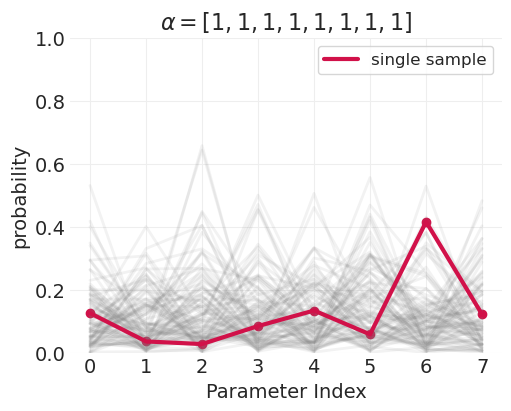

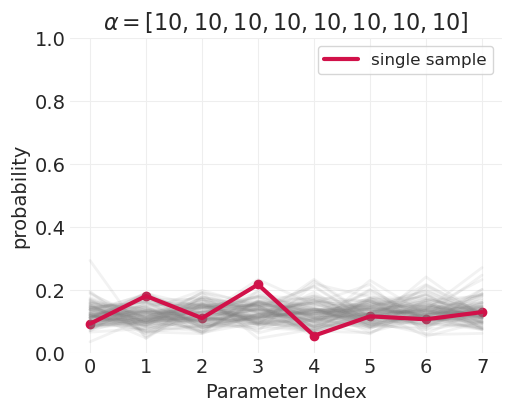

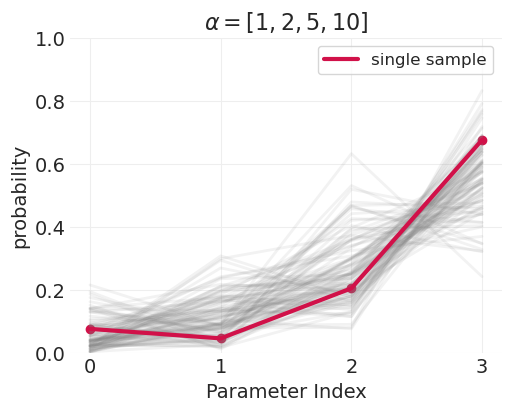

In [26]:
def plot_dirichlet(alpha, n_samples=100, ax=None, random_seed=123):
    """
    `alpha` is a vector of relative parameter importances. Larger
    values make the distribution more concentrated over the mean
    proportion.
    """
    np.random.seed(random_seed)
    if ax is not None:
        plt.sca(ax)
    else:
        _, ax = plt.subplots(figsize=(5, 4))
    dirichlet = stats.dirichlet(alpha)
    dirichlet_samples = dirichlet.rvs(size=n_samples).T
    plt.plot(dirichlet_samples, alpha=0.1, color="gray", linewidth=2)
    plt.plot(
        np.arange(len(alpha)),
        dirichlet_samples[:, 0],
        color="C0",
        linewidth=3,
        label="single sample",
    )
    plt.scatter(np.arange(len(alpha)), dirichlet_samples[:, 0], color="C0")

    plt.xticks(np.arange(len(alpha)))
    plt.xlabel("Parameter Index")
    plt.ylim([0, 1])
    plt.ylabel("probability")
    plt.title(f"$\\alpha={list(alpha)}$")
    plt.legend()


n_ordered_categories = 8
dirichlet_alphas = [
    np.ones(n_ordered_categories).astype(int),
    np.ones(n_ordered_categories).astype(int) * 10,
    np.round((1 + np.arange(4) ** 2), 1),
]

for alphas in dirichlet_alphas:
    plot_dirichlet(alphas)

### Assessing the *Direct Effect* of Education: Stratifying by Gender & Age

McElreath builds a model for the **Total Effect** of gender in the lecture, but then points out that due to the backdoor path caused by gender (via participation), we can't interpret total cause of education. We thus need need to **also stratify by gender**.

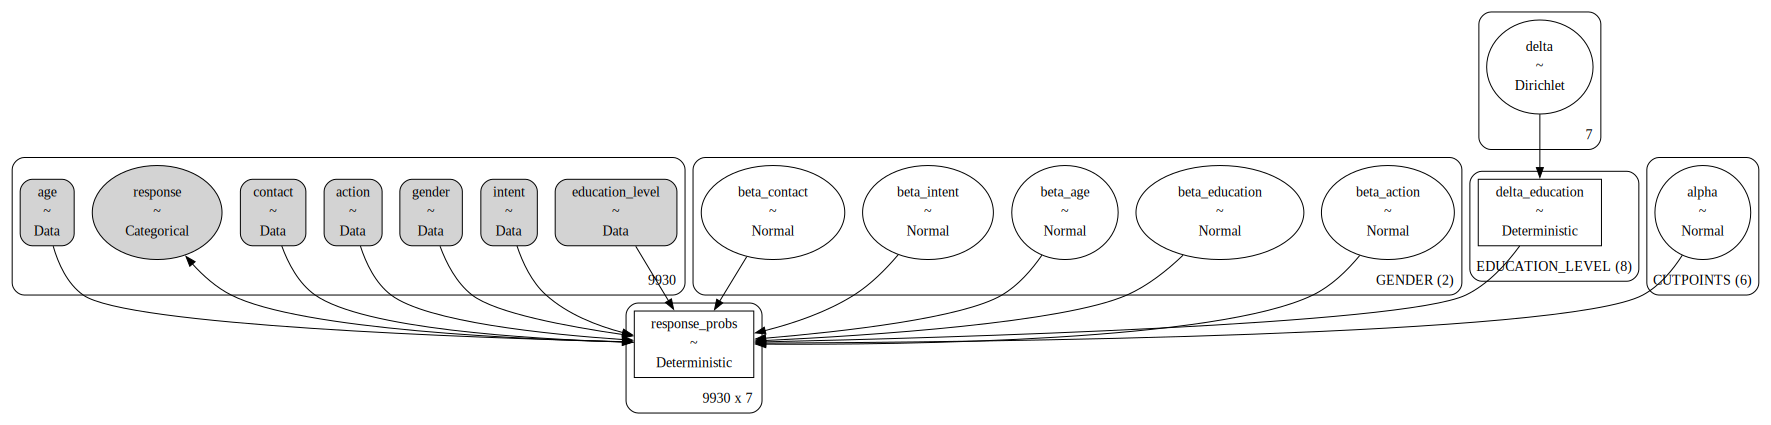

In [27]:
# Add interaction of education level with gender to the dataset
EDUCATION_LEVEL_ID, EDUCATION_LEVEL = pd.factorize(TROLLEY.education_level, sort=True)
EDUCATION_LEVEL = [EDUCUATION_MAP_R[e] for e in EDUCATION_LEVEL]
N_EDUCATION_LEVELS = len(EDUCATION_LEVEL)

AGE = utils.standardize(TROLLEY.age.values)

DIRICHLET_PRIOR_WEIGHT = 2.0

coords = coords = {
    "GENDER": GENDER,
    "EDUCATION_LEVEL": EDUCATION_LEVEL,
    "CUTPOINTS": np.arange(1, N_RESPONSE_CLASSES).astype(int),
}

with pm.Model(coords=coords) as direct_effect_education_model:

    # Data for posterior predictions
    action = pm.Data("action", TROLLEY.action.astype(float))
    intent = pm.Data("intent", TROLLEY.intention.astype(float))
    contact = pm.Data("contact", TROLLEY.contact.astype(float))
    gender = pm.Data("gender", GENDER_ID)
    age = pm.Data("age", AGE)
    education_level = pm.Data("education_level", EDUCATION_LEVEL_ID)

    # Priors (all gender-level parameters)
    beta_action = pm.Normal("beta_action", 0, 0.5, dims="GENDER")
    beta_intent = pm.Normal("beta_intent", 0, 0.5, dims="GENDER")
    beta_contact = pm.Normal("beta_contact", 0, 0.5, dims="GENDER")
    beta_education = pm.Normal("beta_education", 0, 0.5, dims="GENDER")
    beta_age = pm.Normal("beta_age", 0, 0.5, dims="GENDER")

    # Education deltas_{j=1...|E|}.
    delta_dirichlet = pm.Dirichlet(
        "delta", np.ones(N_EDUCATION_LEVELS - 1) * DIRICHLET_PRIOR_WEIGHT
    )

    # Insert delta_0 = 0.0 at index 0 of parameter list
    delta_0 = [0.0]
    delta_education = pm.Deterministic(
        "delta_education", pm.math.concatenate([delta_0, delta_dirichlet]), dims="EDUCATION_LEVEL"
    )

    # For each level of education, the cumulative delta_E, phi_i
    cumulative_delta_education = delta_education.cumsum()

    # Response cut points
    cutpoints = pm.Normal(
        "alpha",
        mu=0,
        sigma=1,
        transform=pm.distributions.transforms.univariate_ordered,
        shape=N_RESPONSE_CLASSES - 1,
        initval=np.arange(N_RESPONSE_CLASSES - 1)
        - 2.5,  # use ordering (with coarse log-odds centering) for init
        dims="CUTPOINTS",
    )

    # Likelihood
    phi = (
        beta_education[gender] * cumulative_delta_education[education_level]
        + beta_age[gender] * age
        + beta_action[gender] * action
        + beta_intent[gender] * intent
        + beta_contact[gender] * contact
    )

    pm.OrderedLogistic("response", cutpoints=cutpoints, eta=phi, observed=RESPONSE_ID)

pm.model_to_graphviz(direct_effect_education_model)

In [28]:
with direct_effect_education_model:
    direct_effect_education_inference = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_action, beta_intent, beta_contact, beta_education, beta_age, delta, alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 145 seconds.


In [29]:
az.summary(
    direct_effect_education_inference,
    var_names=[
        "alpha",
        "beta_action",
        "beta_intent",
        "beta_contact",
        "beta_education",
        "beta_age",
        "delta_education",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[1],-2.892,0.103,-3.082,-2.692,0.003,0.002,1474.0,2003.0,1.01
alpha[2],-2.208,0.101,-2.404,-2.023,0.003,0.002,1518.0,1899.0,1.01
alpha[3],-1.620,0.100,-1.817,-1.439,0.002,0.002,1648.0,1872.0,1.01
alpha[4],-0.579,0.098,-0.775,-0.402,0.002,0.002,1634.0,2087.0,1.01
alpha[5],0.108,0.098,-0.078,0.294,0.002,0.002,1628.0,2018.0,1.01
alpha[6],1.037,0.100,0.833,1.212,0.002,0.002,1657.0,2151.0,1.01
beta_action[F],-0.559,0.059,-0.673,-0.454,0.001,0.001,3411.0,2829.0,1.00
beta_action[M],-0.807,0.054,-0.905,-0.701,0.001,0.001,3840.0,3128.0,1.00
beta_intent[F],-0.662,0.052,-0.757,-0.567,0.001,0.001,3929.0,3222.0,1.00
beta_intent[M],-0.756,0.049,-0.849,-0.663,0.001,0.001,3760.0,2364.0,1.00


In [30]:
# Verify that education deltas are on the 8-simplex
assert np.isclose(
    az.summary(direct_effect_education_inference, var_names=["delta_education"])["mean"].sum(),
    1.0,
    atol=0.01,
)

### Running Counterfactuals

In [31]:
def run_direct_education_counterfactual(
    action=0, intent=0, contact=0, gender=0, education_level=4, ax=None
):
    with direct_effect_education_model:
        pm.set_data(
            {
                "action": xr.DataArray([action] * N_TROLLEY_RESPONSES),
                "intent": xr.DataArray([intent] * N_TROLLEY_RESPONSES),
                "contact": xr.DataArray([contact] * N_TROLLEY_RESPONSES),
                "gender": xr.DataArray([gender] * N_TROLLEY_RESPONSES),
                "education_level": xr.DataArray([education_level] * N_TROLLEY_RESPONSES),
            }
        )
        ppd = pm.sample_posterior_predictive(
            direct_effect_education_inference, extend_inferencedata=False
        )

    # recode back to 1-7
    posterior_predictive = ppd.posterior_predictive["response"] + 1

    if ax is not None:
        plt.sca(ax)
    else:
        plt.subplots(figsize=(6, 3))

    counts, bins = np.histogram(posterior_predictive.values.ravel(), bins=np.arange(1, 9))
    total_counts = counts.sum()
    counts = [c / total_counts for c in counts]
    plt.bar(bins[:-1], counts, width=0.25)

    plt.xlim([0.5, 7.5])
    plt.xlabel("response")
    plt.ylabel("density")
    plt.title(
        f"action={action}; intent={intent}; contact={contact}\ngender={gender}; education_level={education_level}"
    )

Sampling: [response]


Output()

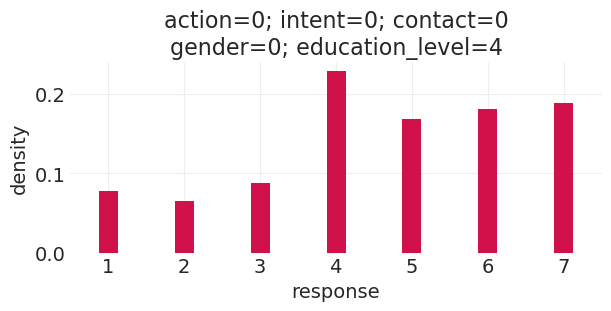

In [32]:
run_direct_education_counterfactual(education_level=4, gender=0)

Sampling: [response]


Output()

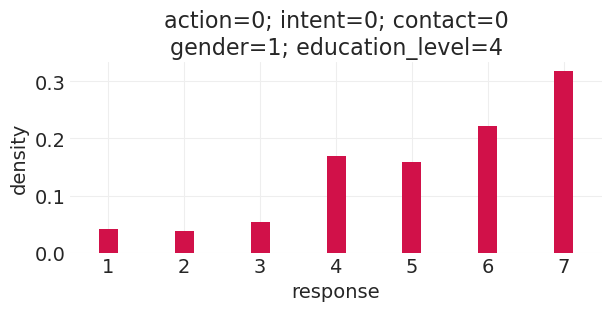

In [33]:
run_direct_education_counterfactual(education_level=4, gender=1)

Sampling: [response]


Output()

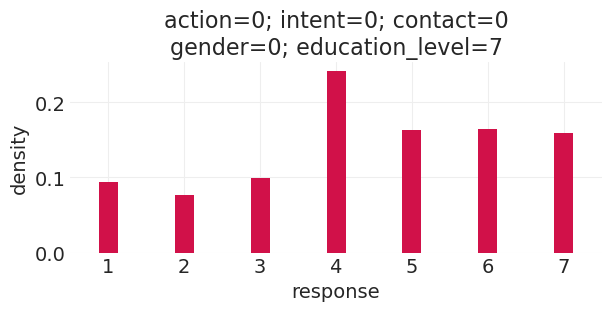

In [34]:
run_direct_education_counterfactual(education_level=7, gender=0)

Sampling: [response]


Output()

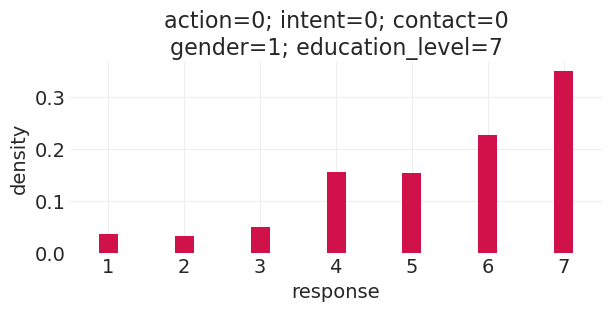

In [35]:
run_direct_education_counterfactual(education_level=7, gender=1)

Sampling: [response]


Output()

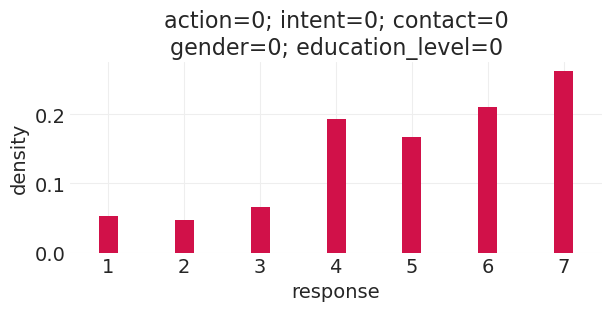

In [36]:
run_direct_education_counterfactual(education_level=0, gender=0)

Sampling: [response]


Output()

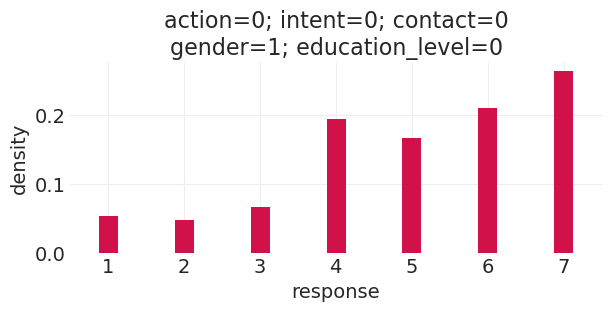

In [37]:
run_direct_education_counterfactual(education_level=0, gender=1)

## Complex Causal Effects
A few lessons here is that complex causal graphs seem like a lot work, but allow us to
- map out an explicit generative model
- map out an explicit estimand for a target causal effect -- we need to identify the correct adjustment set
- generate simulations of nonlinear causal relationships and counterfactuals -- **DON'T DIRECTLY INTERPRET PARAMS, GENERATE PREDICTIONS**

### Repeated Observations
Note that some dimensions have repeat observations -- e.g. the story ID and the responder ID. We can leverage these repeat observations to estimate unobserved phenomena like individual response bias (similar to wine judge discrimination level), or story bias

# BONUS: Description and Causal Inference
Mostly a review of previous studies, not much in terms of technical notes. The main point being that description (and prediction), which are generally  considered orthogonal to causal modeling, actually involve a causal model when performed correctly.

## Things to look out for
- Quality data > bigger data
  - Bigger, biased data magnifies bias
- Better models > averages (XBox poling). Better (causal) models can address unrepresentative samples
- Post-stratification
  - Still effects descriptive models
  - NO CAUSES IN; NO DESCRIPTIONS OUT
- Selection nodes
  - can be incorporated into causal models to capture non-uniform participation
- **The right action depends on the _causes_ of selection**
- Always think carefully about potentially unmodeled selection bias

## 4-step plan for honest digital scholarship
1. Establish what we're trying to describe
2. What is the ideal data for this description?
3. What data do we actually have? This is almost never (2).
4. What are **the causes** of the differences between (2) and (3)?
5. (Optional) Can we use the data we actally have (3) and the model of what caused that data (4) to estimate what we're trying to describe (1)


## Authors
* Ported to PyMC by Dustin Stansbury (2024)
* Based on Statistical Rethinking (2023) lectures by Richard McElreath

In [38]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,aeppl,xarray

Last updated: Tue Dec 17 2024

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.27.0

pytensor: 2.26.4
aeppl   : not installed
xarray  : 2024.7.0

statsmodels: 0.14.2
arviz      : 0.19.0
pandas     : 2.2.2
scipy      : 1.14.1
pymc       : 5.19.1
xarray     : 2024.7.0
matplotlib : 3.9.2
numpy      : 1.26.4

Watermark: 2.5.0



:::{include} ../page_footer.md
:::